# Maritime Trade: Train 2010 - 2019 XGBoost GPU
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import warnings
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor, plot_importance
import joblib
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 
from eli5.sklearn import PermutationImportance 
import webbrowser
from eli5.formatters import format_as_dataframe
import shap
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 911 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 7.0 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 33.3 MB/s 
     |████████████████████████████████| 133 kB 68.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=f42211c08e83a6ba2902a18d8baeb9558643cc32cbeee05061d4d01b844bb65b
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    F

In [ ]:
# Set seed 
seed_value = 42
os.environ['XGBoostGPU_preCovid'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (24133210, 19)


In [ ]:
# Sample due to memory constraints
df_sample = df.sample(n=10000000)

del df

In [ ]:
# X,y for encoding
X = df_sample.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df_sample.loc[:, ['Metric_Tons']]

del df_sample

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.Year,
                                                    random_state=seed_value)

In [ ]:
# Drop year variable
X_train = X_train.drop(['Year'], axis=1)
X_test = X_test.drop(['Year'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


## 100 Trials 10-Fold Cross Validation

In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO""" 

    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,        
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start
    
    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_preCovid_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-18 13:01:18.188058
100%|██████████| 100/100 [10:00:00<00:00, 360.00s/it, best loss: 403.2773035114759]
Start Time           2022-02-18 13:01:18.188058
End Time             2022-02-18 23:01:18.588852
10:00:00


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 403.2773035114759, 'params': {'colsample_bylevel': 0.45517050590918035, 'colsample_bytree': 0.8723684407739156, 'gamma': 7.1488653736627175, 'learning_rate': 0.0375170061509599, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 181, 'reg_alpha': 1, 'reg_lambda': 2.474494446712119, 'subsample': 0.5969789590672573}, 'iteration': 30, 'train_time': 398.708583394, 'status': 'ok'}, {'loss': 403.41838346407724, 'params': {'colsample_bylevel': 0.4991203928074714, 'colsample_bytree': 0.9106445650339271, 'gamma': 5.751525141506594, 'learning_rate': 0.014651641643829757, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 436, 'reg_alpha': 17, 'reg_lambda': 1.3258370510024116, 'subsample': 0.5420074791772036}, 'iteration': 40, 'train_time': 844.5853260760014, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_preCovid_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_preCovid_100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_preCOVID_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train preCOVID 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train preCOVID 100 GPU trials
MAE train: 7.294, test: 8.603
MSE train: 231.268, test: 309.714
RMSE train: 15.207, test: 17.599
R^2 train: 0.673, test: 0.564


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 318004.05175 MSE on the test set.
This was achieved after 30 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_preCovid_100_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

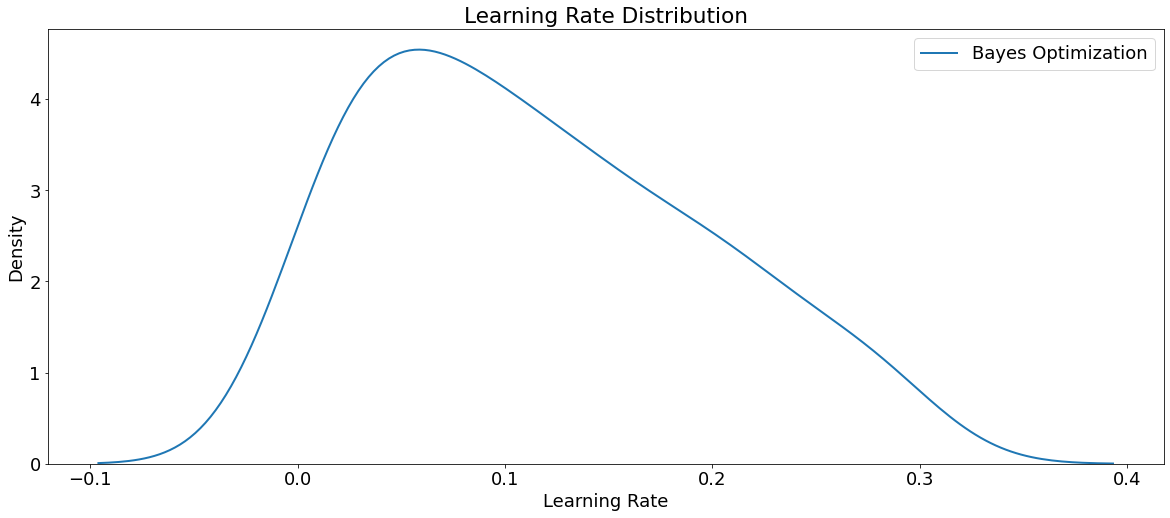

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

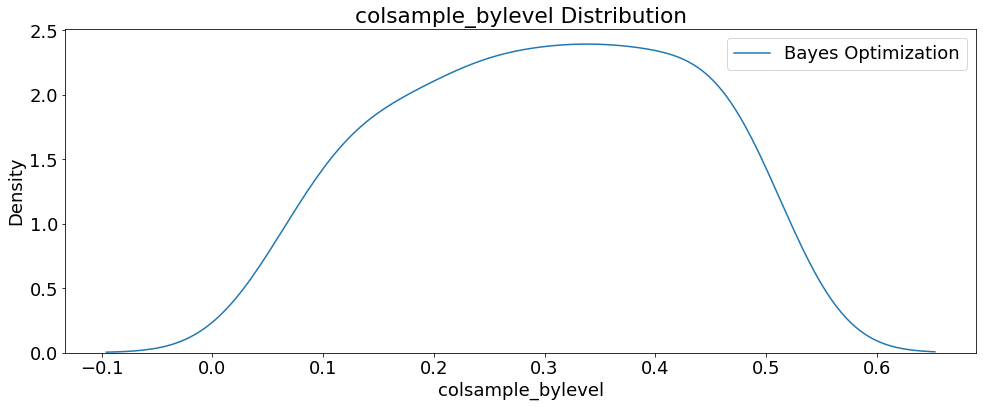

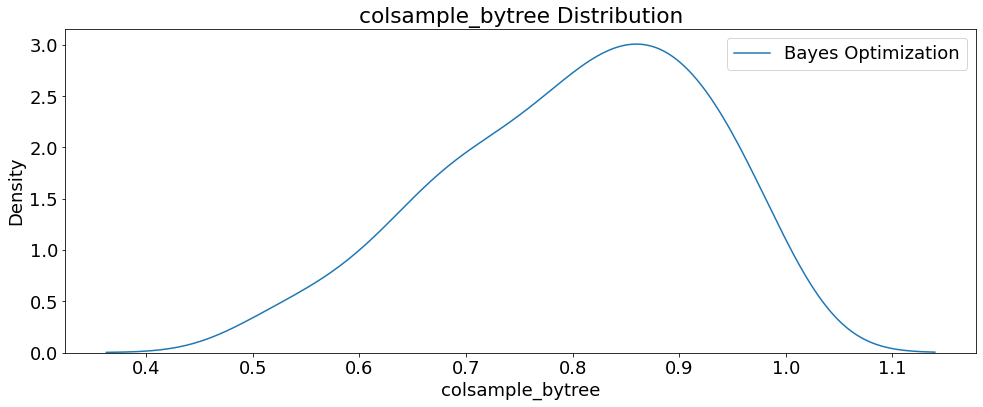

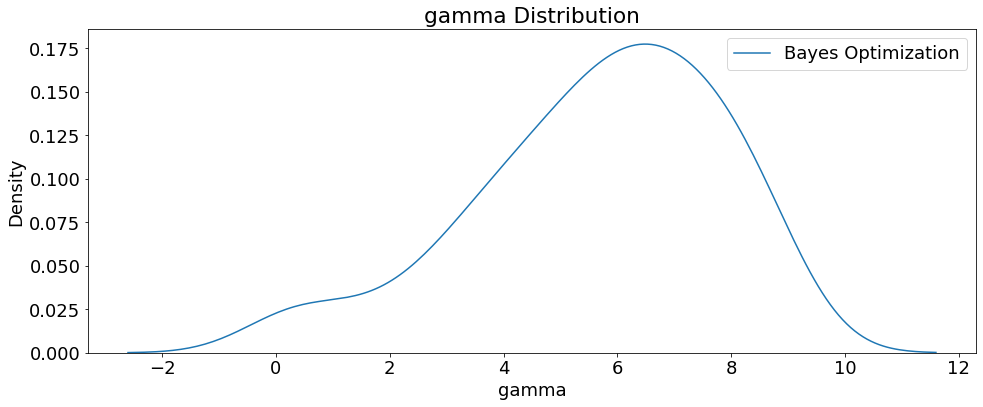

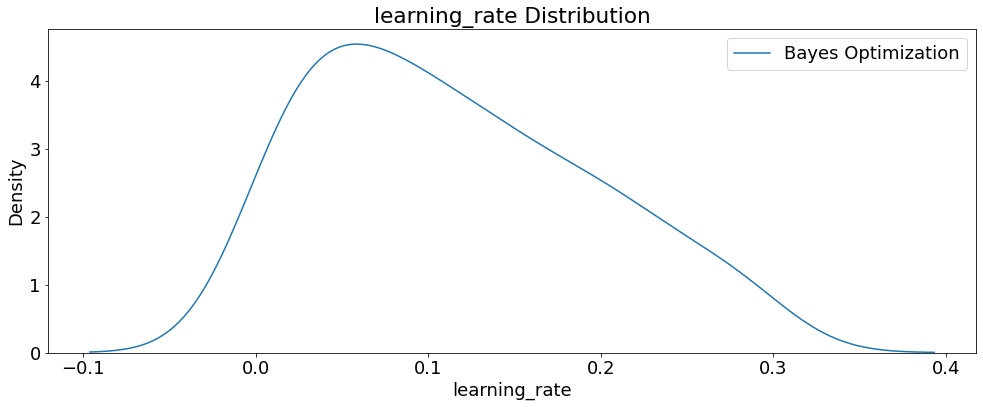

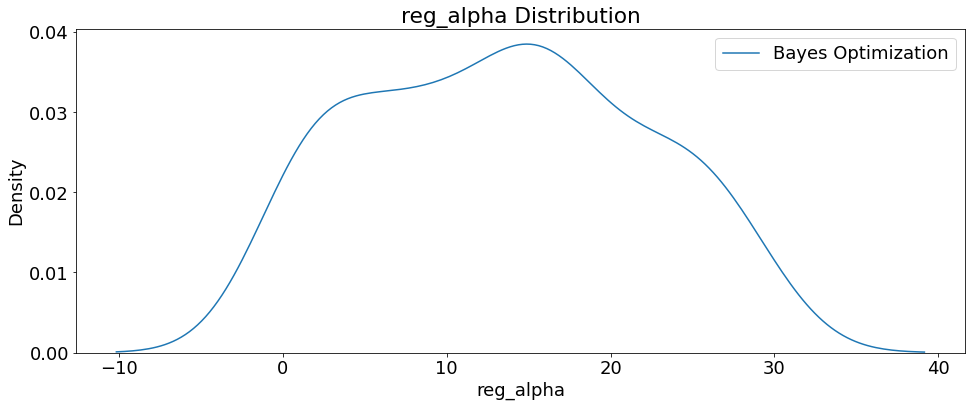

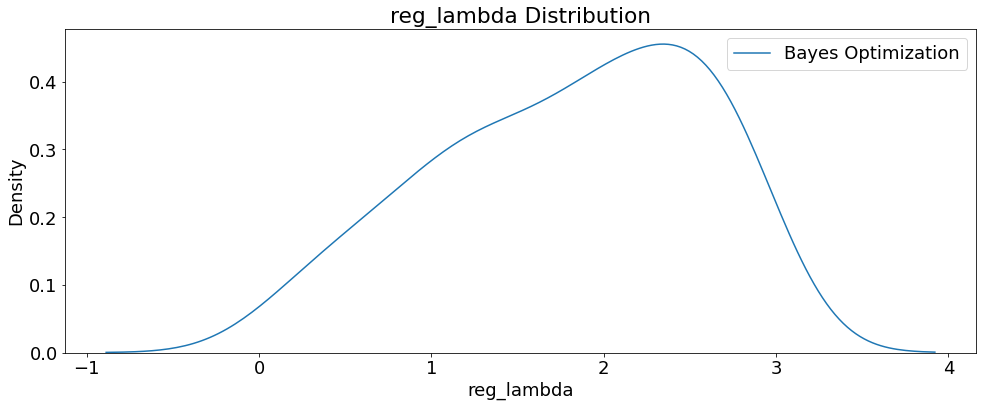

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

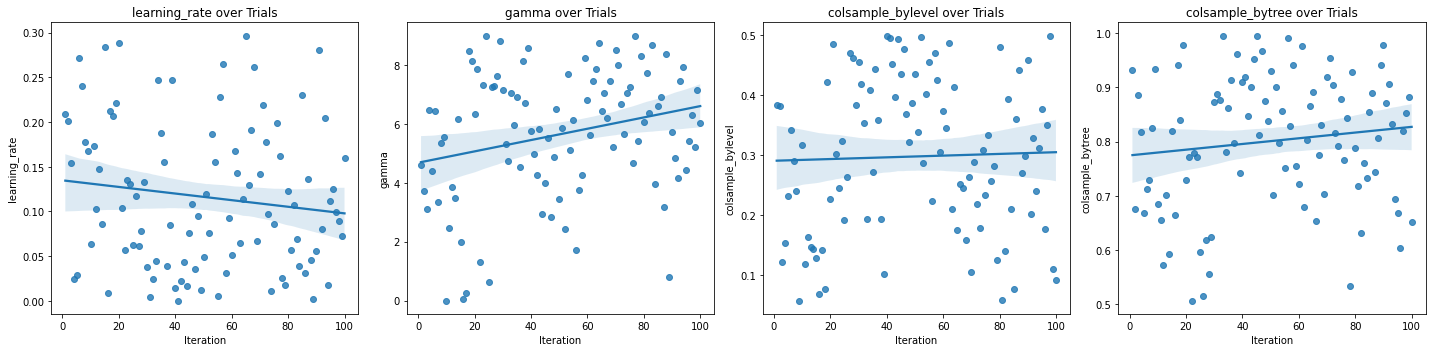

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

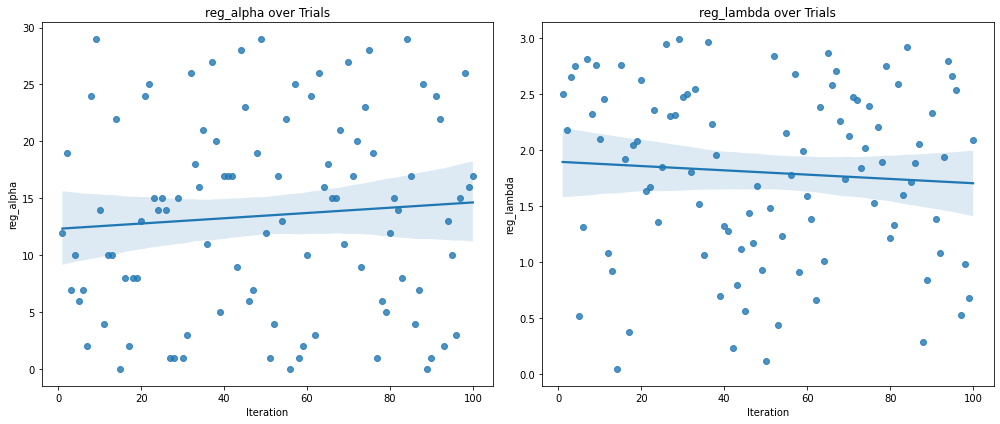

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']): 
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
  title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


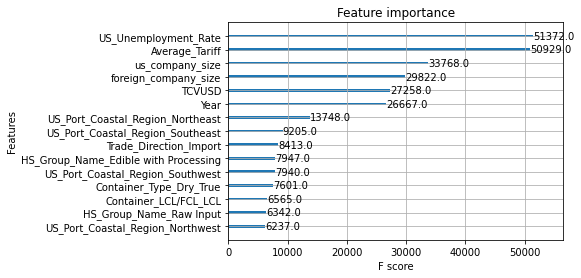

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_preCovid_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

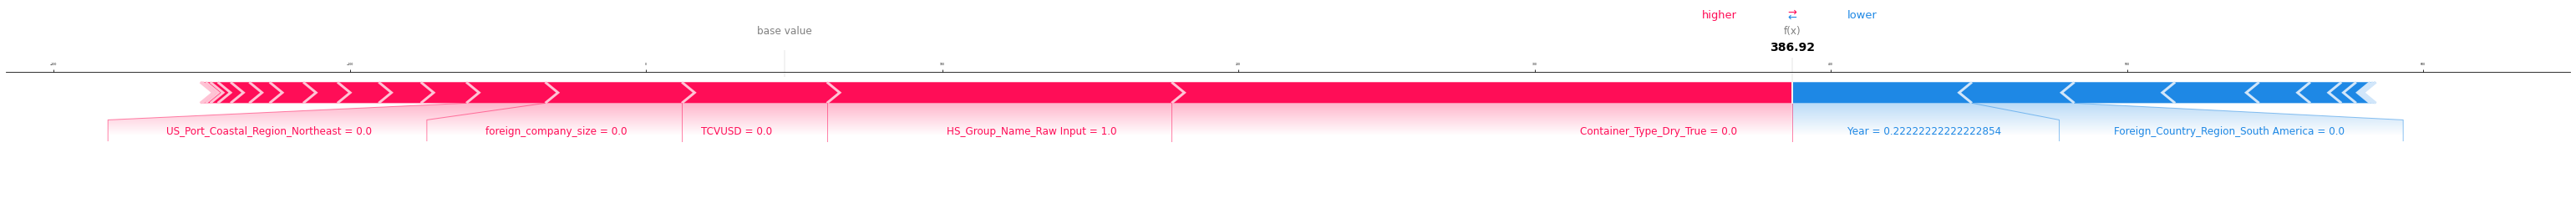

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_trainPreCOVIDtestPreCOVID_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

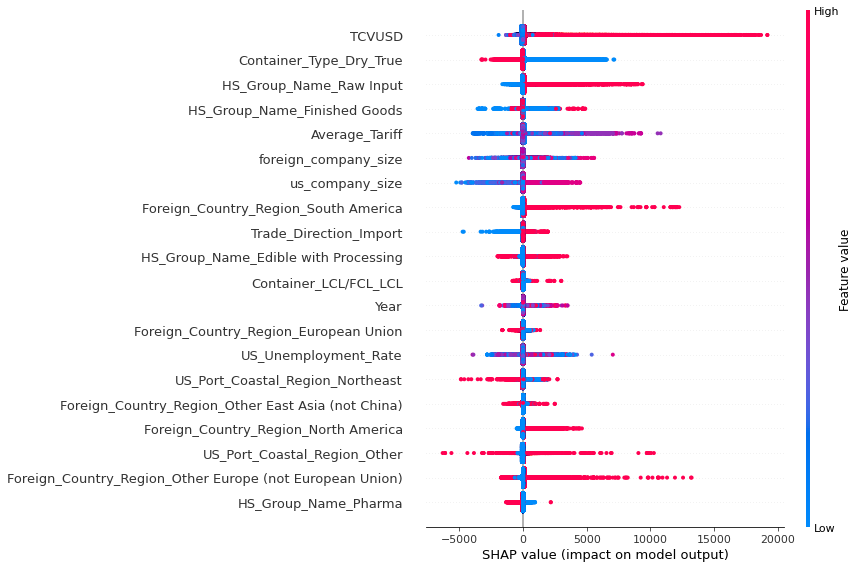

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_100_GPU_trainPreCOVIDtestPreCOVID_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

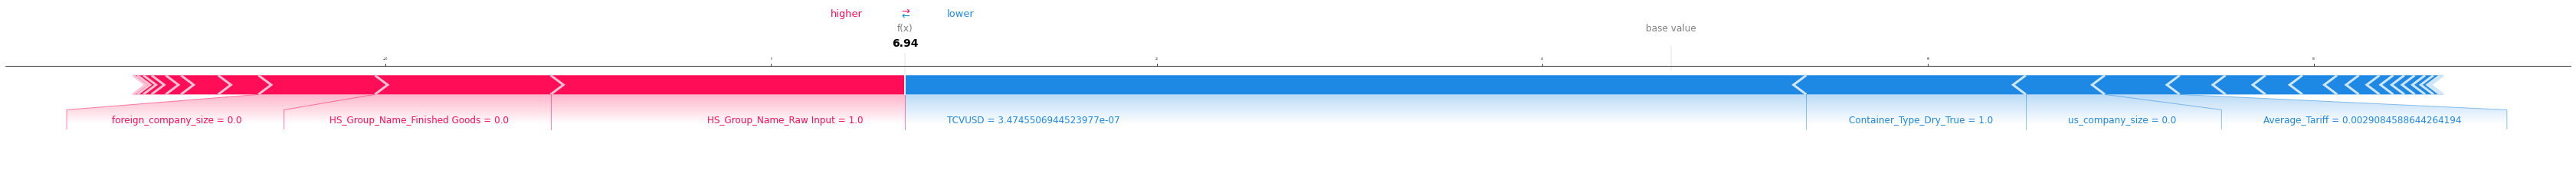

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_100_GPU_trainPreCOVIDtestPreCOVID_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

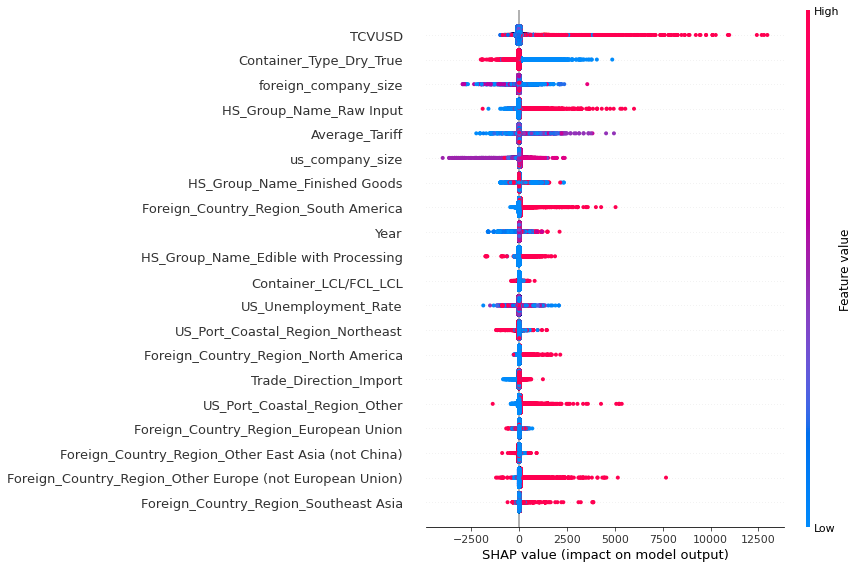

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_100_GPU_trainPreCOVIDtestPreCOVID_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_preCovid_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_preCovid_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_TrainPreCOVIDTestPreCOVID_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.229714  0.002373
1                             Container_Type_Dry_True  0.116695  0.003748
2                             HS_Group_Name_Raw Input  0.077732  0.003306
3                                      Average_Tariff  0.064303  0.003565
4                                                Year  0.041310  0.002205
5                Foreign_Country_Region_South America  0.037186  0.000639
6                HS_Group_Name_Edible with Processing  0.011761  0.000547
7                        HS_Group_Name_Finished Goods  0.010787  0.000721
8                              Trade_Direction_Import  0.010677  0.000845
9   Foreign_Country_Region_Other Europe (not Europ...  0.009025  0.000782
10               Foreign_Country_Region_North America  0.008058  0.000838
11                       US_Port_Coastal_Region_Other  0.007632  0.000338
12                   US_Port_Coastal_Region_Northeast  0.007352  0.002869
13                               US_Unemployment_Rate  0.007250  0.001942
14                   US_Port_Coastal_Region_Southwest  0.005004  0.001201
15  Foreign_Country_Region_Middle East & North Africa  0.004157  0.000213
16              Foreign_Country_Region_European Union  0.003447  0.000468
17              Foreign_Country_Region_Southeast Asia  0.003410  0.001412
18                   US_Port_Coastal_Region_Southeast  0.003361  0.003522
19                               HS_Group_Name_Pharma  0.002815  0.000233

### Test trained 2010-19 model on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6703389, 22)


In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

In [ ]:
# Prepare 2020 to fit model train on 2010-19
X_test1 = df.drop(['Metric_Tons', 'DateTime', 'Year'], axis=1)
y_test1 = df['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2010-19 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2010-19 Test 2020
MAE train: 7.294, test: 5.935
MSE train: 231.268, test: 156.300
RMSE train: 15.207, test: 12.502
R^2 train: 0.673, test: 0.754


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


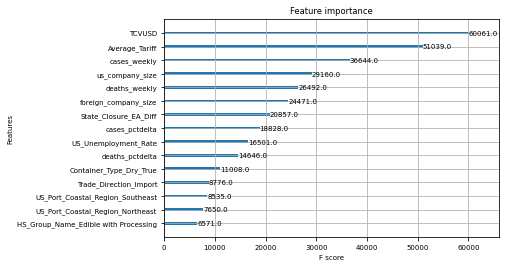

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_trainPreCOVIDTest20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

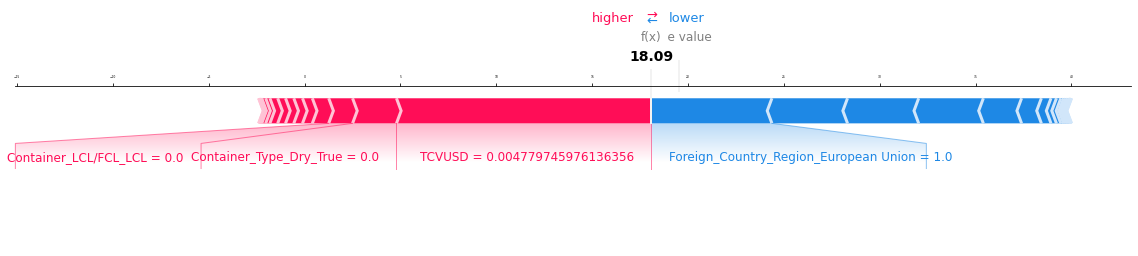

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGBoost_HPO_100_GPU_trainPreCOVIDTest20_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, 
                                                     bbox_inches='tight');

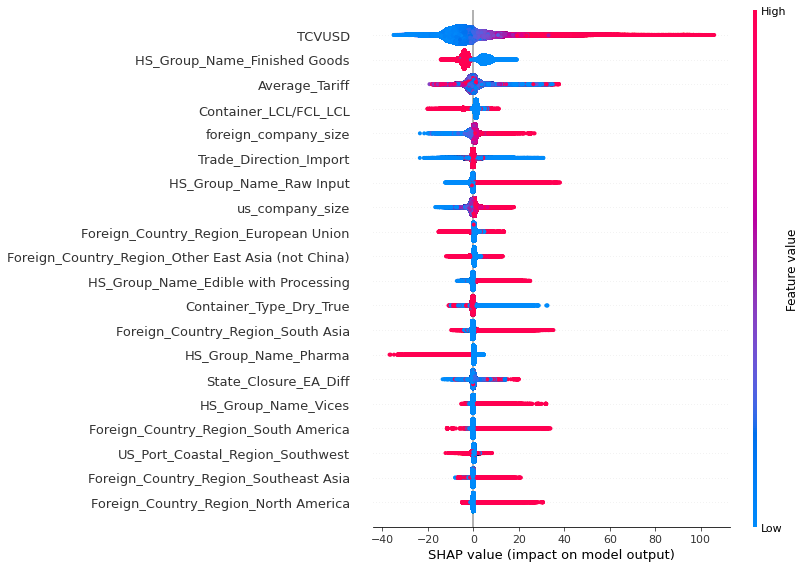

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_trainPreCOVIDTest20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_trainPreCOVIDTest20_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_trainPreCOVIDTest20_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_trainPreCOVIDTest20_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.893039  0.000509
1                                      Average_Tariff  0.275159  0.000292
2                    US_Port_Coastal_Region_Northwest  0.180742  0.000428
3                              Trade_Direction_Import  0.129776  0.000355
4                    US_Port_Coastal_Region_Southeast  0.110817  0.000180
5                                                Year  0.075851  0.000179
6                                     us_company_size  0.065853  0.000201
7                             Container_Type_Dry_True  0.051380  0.000292
8                    US_Port_Coastal_Region_Northeast  0.046664  0.000133
9                                HS_Group_Name_Pharma  0.041910  0.000168
10                              State_Closure_EA_Diff  0.036640  0.000172
11  Foreign_Country_Region_Other Europe (not Europ...  0.035317  0.000087
12          Foreign_Country_Region_Sub Saharan Africa  0.029991  0.000108
13                              Container_LCL/FCL_LCL  0.027277  0.000106
14                       US_Port_Coastal_Region_Other  0.026774  0.000061
15                            HS_Group_Name_Raw Input  0.020116  0.000056
16                       HS_Group_Name_Finished Goods  0.019592  0.000051
17                  Foreign_Country_Region_South Asia  0.019311  0.000060
18                   US_Port_Coastal_Region_Southwest  0.018237  0.000010
19  Foreign_Country_Region_Middle East & North Africa  0.015699  0.000096

## 300 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

# File to save first results
out_file = 'XGB_HPO_preCovid_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

# Stopped at 205/300 trials due to runtime length

Start Time           2022-03-27 02:56:10.569447
 68%|██████▊   | 205/300 [19:58:00<7:37:17, 288.81s/it, best loss: 421.30116789824723]

In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_preCovid_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                verbosity=0, 
                                random_state=seed_value, 
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_preCovid_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_preCOVID_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train preCOVID 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train preCOVID 300 GPU trials
MAE train: 7.249, test: 8.685
MSE train: 228.104, test: 309.972
RMSE train: 15.103, test: 17.606
R^2 train: 0.677, test: 0.564


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, 
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 474302.14356 MSE on the test set.
This was achieved after 35 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_preCovid_300_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

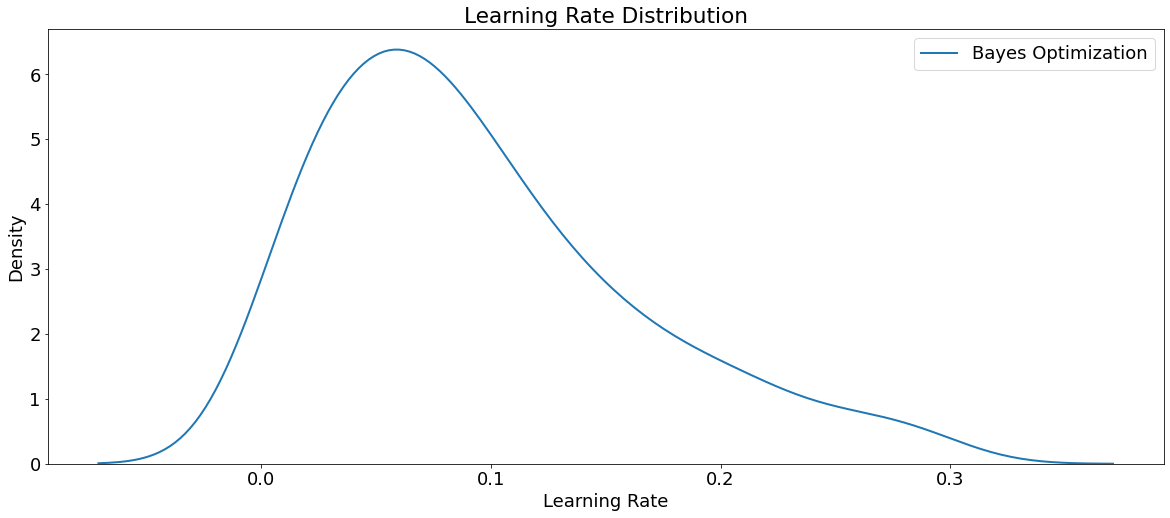

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

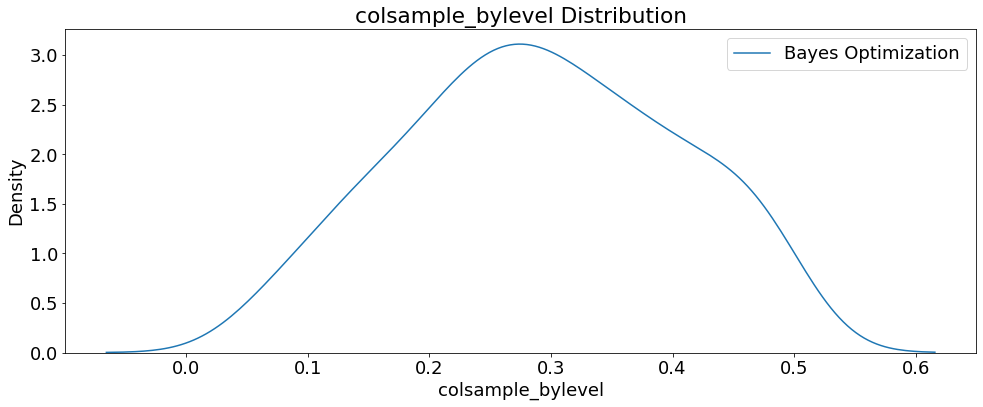

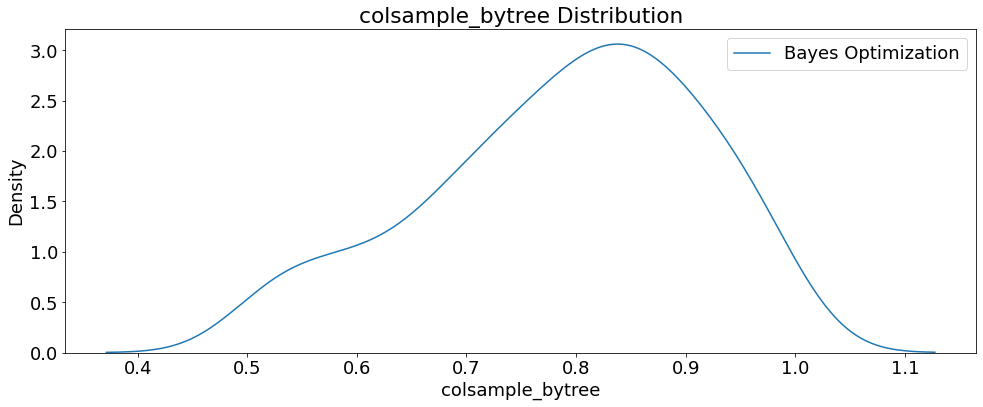

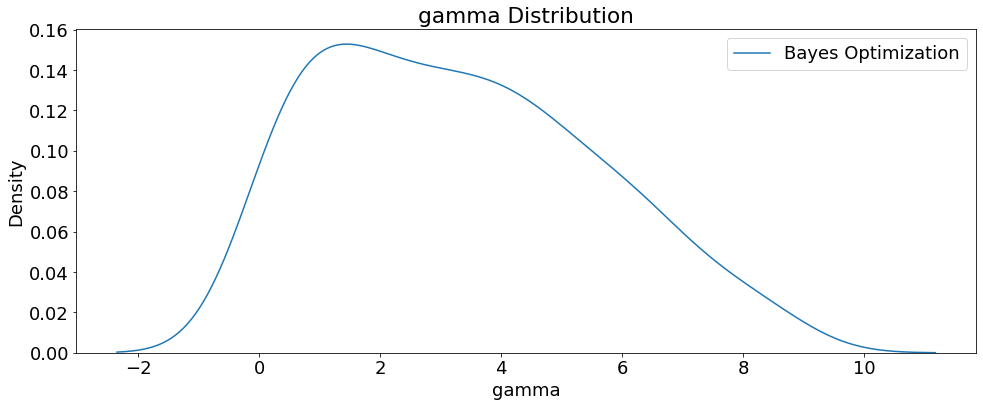

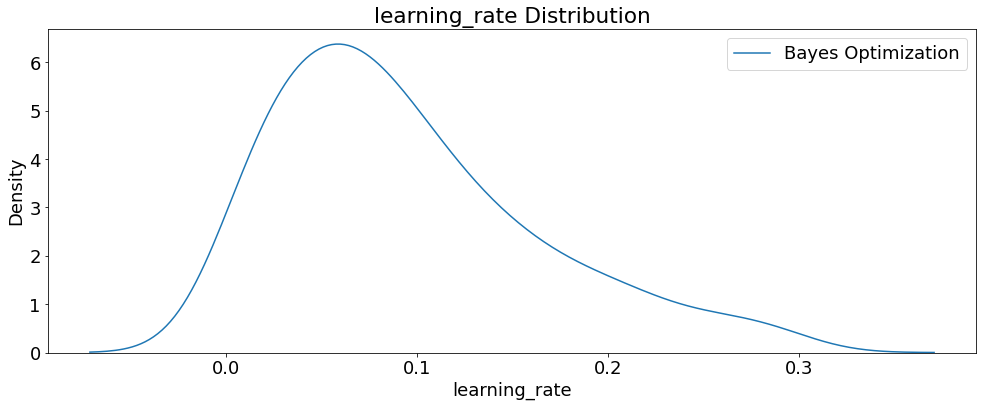

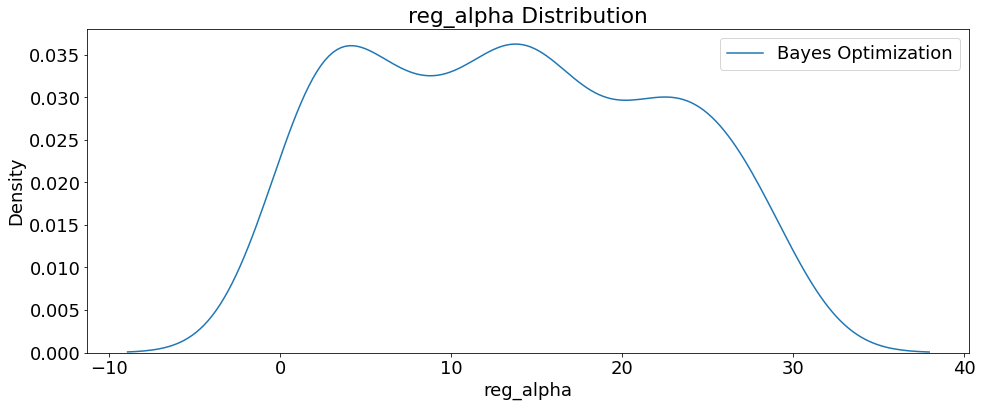

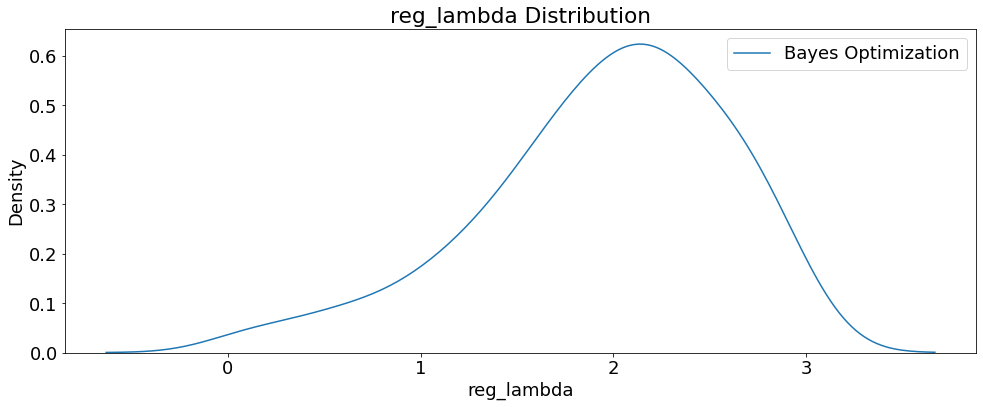

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

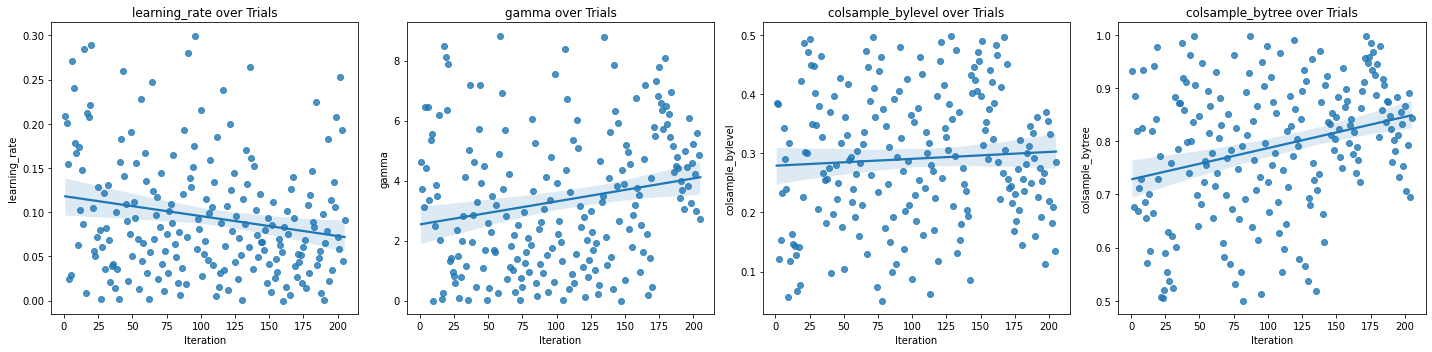

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']): 
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

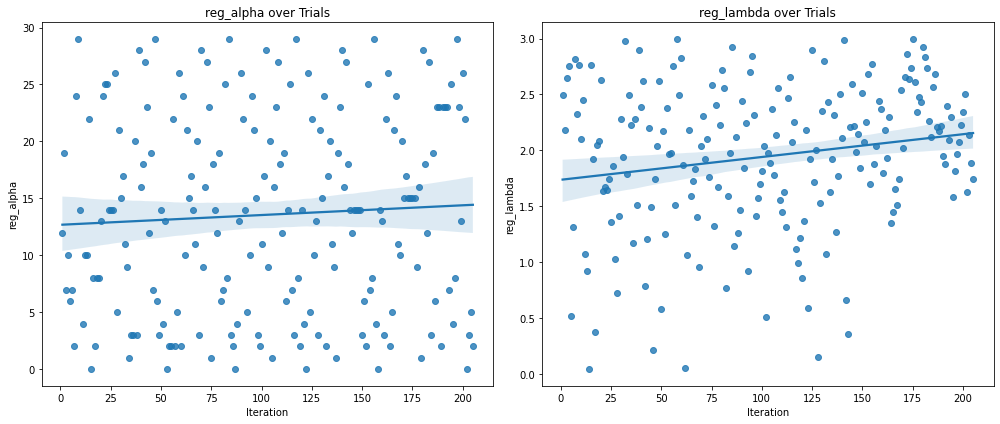

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
  sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


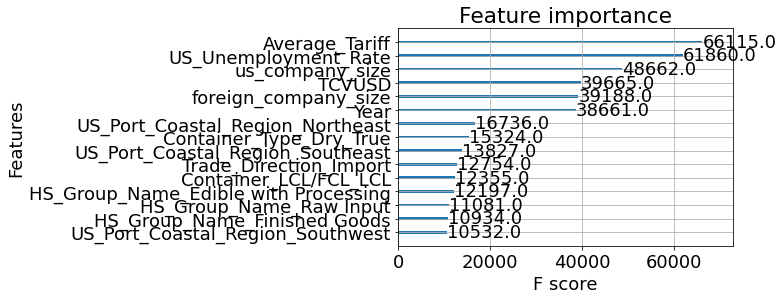

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_preCovid_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

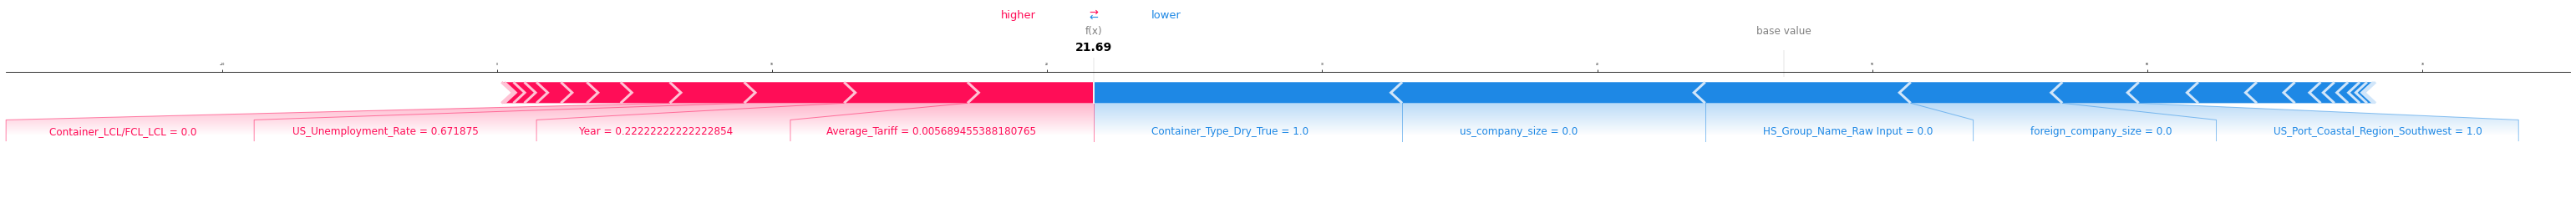

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_trainPreCOVIDtestPreCOVID_ShapForcePlot_TrainSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

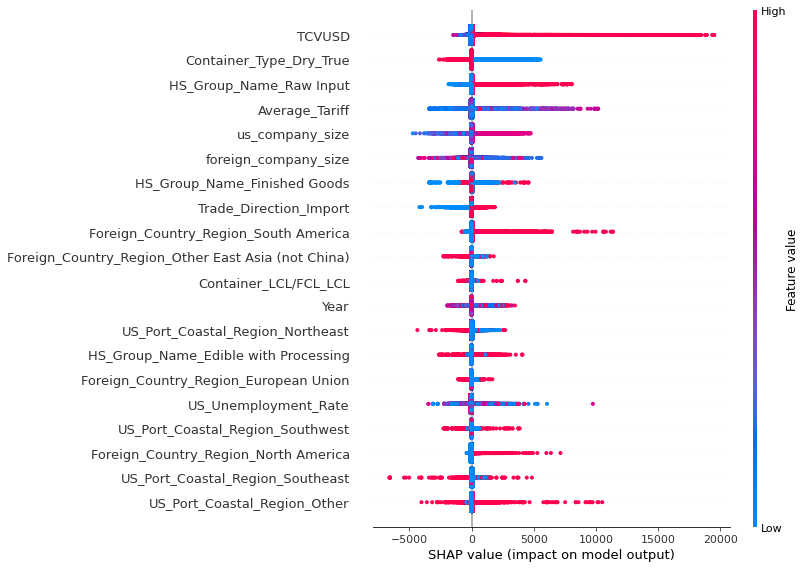

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_300_GPU_trainPreCOVIDtestPreCOVID_ShapSummary_TrainSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

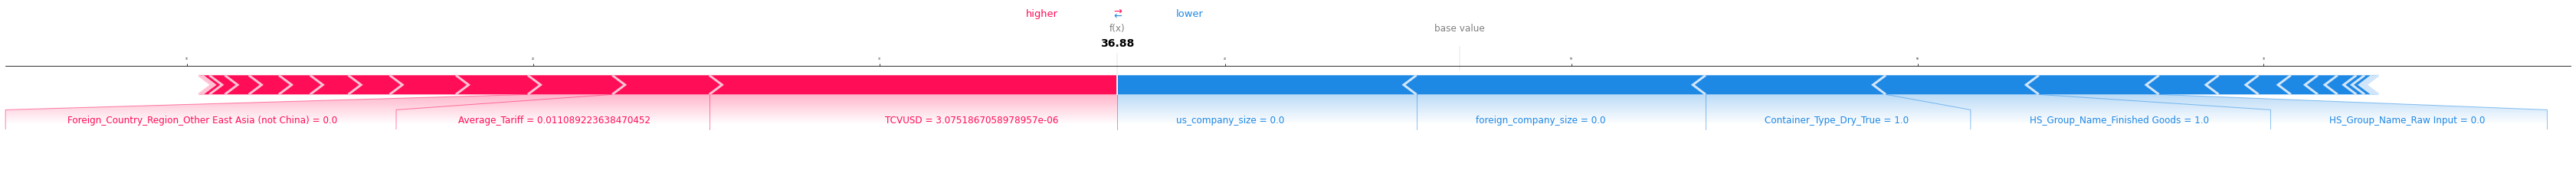

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True, figsize=(60,3)).savefig('XGBoost_HPO_300_GPU_trainPreCOVIDtestPreCOVID_ShapForcePlot_TestSet.png', 
                                                                     dpi=my_dpi*10, 
                                                                     bbox_inches='tight');

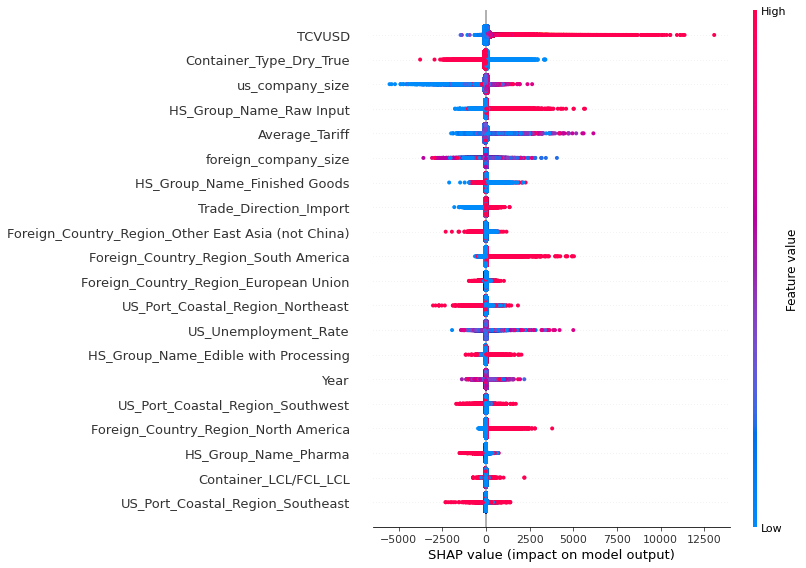

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_300_GPU_trainPreCOVIDtestPreCOVID_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Results/best_bayes_preCovid_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Results/best_bayes_preCovid_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance, 
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_trainPreCOVIDTestPreCOVID_HPO_300_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.540398  0.018794
1                                     us_company_size  0.068912  0.008825
2                                      Average_Tariff  0.056578  0.003178
3                                HS_Group_Name_Pharma  0.054025  0.000321
4                                US_Unemployment_Rate  0.039257  0.002881
5                                                Year  0.038514  0.001325
6                        HS_Group_Name_Finished Goods  0.023185  0.002898
7                Foreign_Country_Region_South America  0.018747  0.002368
8                    US_Port_Coastal_Region_Northeast  0.017072  0.002679
9               Foreign_Country_Region_Southeast Asia  0.016535  0.001293
10  Foreign_Country_Region_Other Europe (not Europ...  0.015844  0.001836
11                             Trade_Direction_Import  0.015466  0.003025
12  Foreign_Country_Region_Other East Asia (not Ch...  0.011549  0.000714
13                                HS_Group_Name_Vices  0.006945  0.000702
14                   US_Port_Coastal_Region_Southwest  0.004043  0.004175
15                   US_Port_Coastal_Region_Northwest  0.003470  0.000908
16                   US_Port_Coastal_Region_Southeast  0.001601  0.002764
17                     Foreign_Country_Region_Oceania  0.001129  0.000272
18                  Foreign_Country_Region_South Asia  0.001015  0.000522
19          Foreign_Country_Region_Sub Saharan Africa  0.000391  0.000057

### Test trained 2010-19 Model on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

In [ ]:
# Prepare 2020 to fit model train on 2010-19
X_test1 = df.drop(['Metric_Tons', 'DateTime', 'Year'], axis=1)
y_test1 = df['Metric_Tons']

In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2010-19 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2010-19 Test 2020
MAE train: 25.353, test: 5.704
MSE train: 124171.425, test: 142.402
RMSE train: 352.380, test: 11.933
R^2 train: 0.678, test: 0.771


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


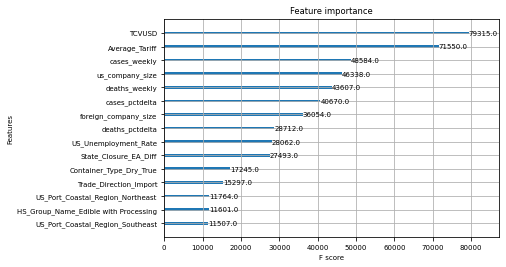

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGB_HPO_trainPreCOVIDTest20_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

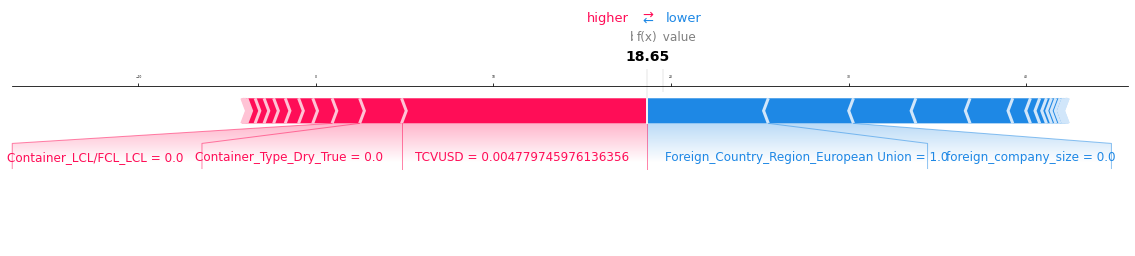

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:], 
                show=False, matplotlib=True).savefig('XGB_HPO_300_GPU_trainPreCOVIDTest20_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi*10, 
                                                     bbox_inches='tight');

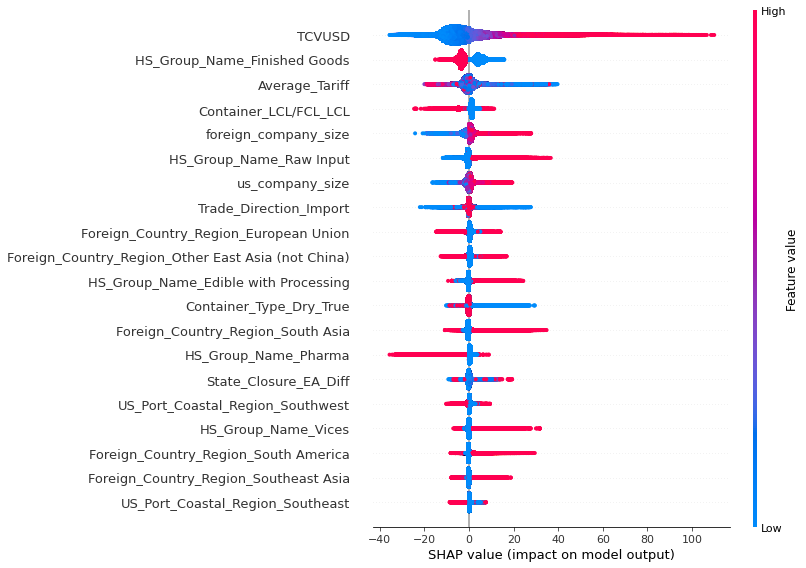

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGB_HPO_300_GPU_trainPreCOVIDTest20_ShapSummary_TestSet.png', 
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)                                                                    

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Results/best_bayes_trainPreCOVIDTest20_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Results/best_bayes_trainPreCOVIDTest20_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance, 
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_trainPreCOVIDTest20_HPO_300_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.898736  0.000375
1                                      Average_Tariff  0.276665  0.000347
2                    US_Port_Coastal_Region_Northwest  0.142791  0.000351
3                              Trade_Direction_Import  0.117891  0.000322
4                    US_Port_Coastal_Region_Southeast  0.106576  0.000171
5                                                Year  0.077955  0.000202
6                                     us_company_size  0.076160  0.000210
7                             Container_Type_Dry_True  0.049991  0.000257
8                    US_Port_Coastal_Region_Northeast  0.049444  0.000090
9   Foreign_Country_Region_Other Europe (not Europ...  0.046962  0.000149
10                              State_Closure_EA_Diff  0.040736  0.000194
11          Foreign_Country_Region_Sub Saharan Africa  0.039489  0.000143
12                               HS_Group_Name_Pharma  0.038840  0.000145
13                              Container_LCL/FCL_LCL  0.029423  0.000112
14                       US_Port_Coastal_Region_Other  0.028308  0.000043
15                   US_Port_Coastal_Region_Southwest  0.020695  0.000048
16                            HS_Group_Name_Raw Input  0.020397  0.000063
17                       HS_Group_Name_Finished Goods  0.020039  0.000093
18                  Foreign_Country_Region_South Asia  0.018100  0.000070
19  Foreign_Country_Region_Middle East & North Africa  0.017488  0.000105